# An implementation of the online iHMM

In this note, we build the online infinite hidden-Markov model (iHMM) from scratch: we start with a finite hidden-Markov model and gradually build
our way to the online iHMM.

In [99]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [100]:
%config InlineBackend.figure_format = "retina"

In [8]:
key = jax.random.PRNGKey(314)
key_sample, key_run = jax.random.split(key)

(Hidden definition of new macros)
$\newcommand{\vP}{\boldsymbol P}$

## A hidden markov model

In [102]:
transition_matrix = jnp.array([
    [0.99, 0.05, 0.05],
    [0.05, 0.99, 0.05],
    [0.05, 0.05, 0.99],
])

means = jnp.array([-1, 0, 1])
num_regimes = len(means)

In [103]:
def step(state, key):
    key_state, key_noise = jax.random.split(key)
    proba_change = transition_matrix[state]
    state_next = jax.random.choice(key, len(proba_change), p=proba_change)

    err = jax.random.normal(key_noise) * 0.2
    obs = means[state_next] + err

    return state_next, (state_next, obs)

In [104]:
state_init = 0
timesteps = 500

keys = jax.random.split(key_sample, timesteps)
_, (states, obs) = jax.lax.scan(step, state_init, keys)

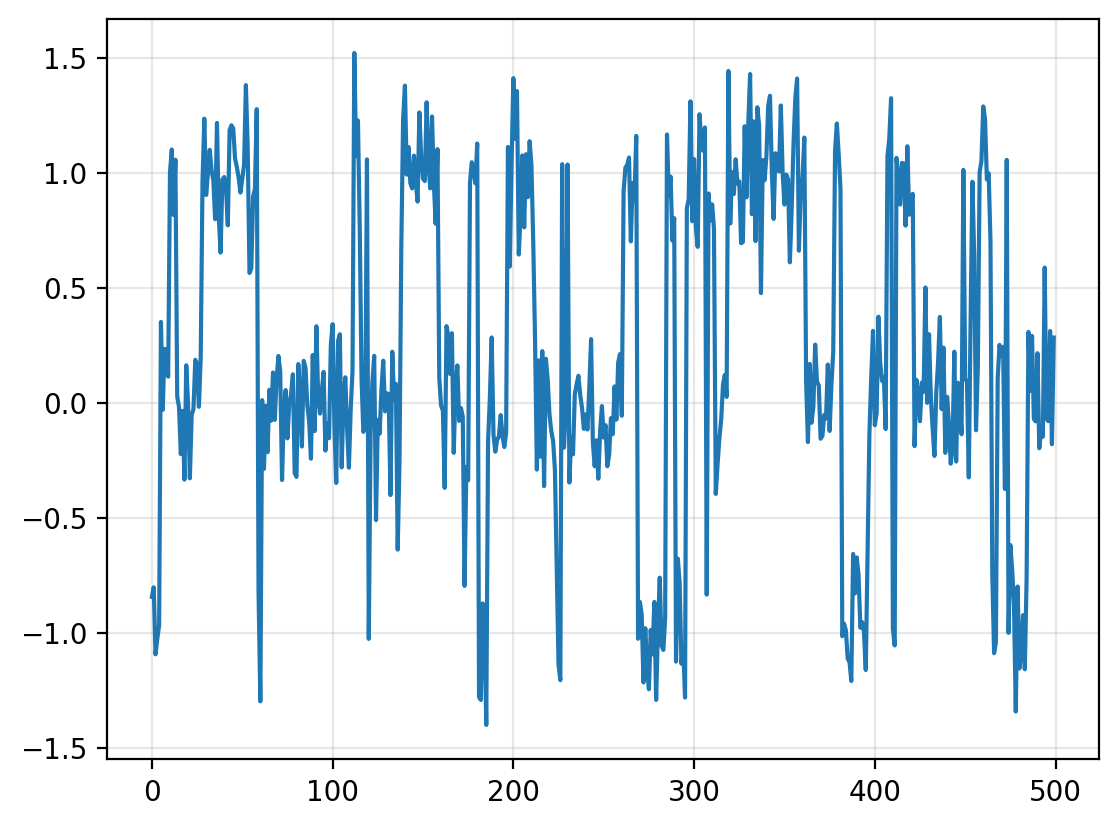

In [105]:
plt.plot(obs)
plt.grid(alpha=0.3)

---

## Finite hidden state-space model (v.0)

The transition probabilities are known.

We consider the following HMM assumption
$$
\begin{aligned}
    p(s_t \mid s_{t-1}) &= \pi_{s_t,\,s_{t-1}}\\
    p(\Theta \mid s_t) &= {\cal N}(\theta_{s_t} \mid m_0, s_0^2)\\
    p(y_t \mid \Theta, s_t) &= {\cal N}(y_t \mid \theta_{s_t},\,\sigma^2)
\end{aligned}
$$

with $\pi_{i,j}$ known for all $i,j$.

---

## Finite hidden state-space model (v.1)

Transition probabilities are not known.

A sticky-HMM assumption.

We consider the following HMM assumption
$$
\begin{aligned}
    \boldsymbol\pi_\ell &\sim {\rm Dir}(\alpha + \kappa\,\boldsymbol e_\ell) \quad\, \forall \ell\in\{1,\ldots, K\}\\
    p(s_t \mid s_{t-1}) &= \pi_{s_t,\,s_{t-1}}\\
    p(\Theta \mid s_t) &= {\cal N}(\theta_{s_t} \mid m_0, s_0^2)\\
    p(y_t \mid \Theta, s_t) &= {\cal N}(y_t \mid \theta_{s_t},\,\sigma^2)
\end{aligned}
$$

In [106]:
alpha = 0.5
kappa = 1
regime = 1

ohe_regime = jax.nn.one_hot(regime, num_regimes)

proba_regimes = alpha + kappa * ohe_regime
jax.random.dirichlet(key_pi, proba_regimes).round(2)

Array([0.06, 0.32, 0.62], dtype=float32)

Let $\psi_t \in \{1, 2, \ldots, K\}^t$. We seek

$$
\begin{aligned}
    p(\psi_t, \boldsymbol P \mid y_{1:t})
    &= \sum_{\psi_t \in \Psi_t}
\end{aligned}
$$

Let $\psi_t \in \{1, 2, \ldots, K\}^t$. We seek

$$
\begin{aligned}
    p(\psi_t \mid y_{1:t})
    &= \sum_{\psi_{t-1}\in\Psi_{t-1}} p(\psi_t, \psi_{t-1} \mid y_{1:t})\\
    &= \sum_{\psi_{t-1} \in \Psi_{t-1}}\int p(\vP, \psi_t, \psi_{t-1} \mid y_{1:t}) d\vP\\
    &= \int \sum_{\psi_{t-1} \in \Psi_{t-1}} p(\vP, \psi_t, \psi_{t-1} \mid y_{1:t-1}, y_t) d\vP\\
    &\propto \int \sum_{\psi_{t-1} \in \Psi_{t-1}} p(\vP, \psi_t, \psi_{t-1} \mid y_{1:t-1}) p(y_t \mid \vP, \psi_t, \psi_{t-1}, y_{1:t}) d\vP \\
    &= \int \sum_{\psi_{t-1} \in \Psi_{t-1}} p(\vP, \psi_t, \psi_{t-1} \mid y_{1:t-1}) p(y_t \mid \psi_t, y_{1:t-1}) d\vP \\
    &= p(y_t \mid \psi_t, y_{1:t-1})
    \sum_{\psi_{t-1} \in \Psi_{t-1}} \int
    p(\vP, \psi_t, \psi_{t-1} \mid y_{1:t-1}) d\vP \\
    &=
    p(y_t \mid \psi_t, y_{1:t-1})
    \sum_{\psi_{t-1} \in \Psi_{t-1}}\int 
    p(\vP \mid y_{1:t-1})\,
    p(\psi_{t-1} \mid \vP, y_{1:t-1})\,
    p(\psi_t \mid \psi_{t-1}, \vP, y_{1:t-1})
    d\vP \\
    &= p(y_t \mid \psi_t, y_{1:t-1})
    \sum_{\psi_{t-1} \in \Psi_{t-1}}
    \int
    p(\vP \mid y_{1:t-1})\,
    p(\psi_{t-1} \mid y_{1:t-1})\,
    p(\psi_t \mid \psi_{t-1}, \vP)
    d\vP \\
    &= p(y_t \mid \psi_t, y_{1:t-1})
    \sum_{\psi_{t-1} \in \Psi_{t-1}}
    p(\psi_{t-1} \mid y_{1:t-1})\,
    \int
    p(\vP \mid y_{1:t-1})\,
    p(\psi_t \mid \psi_{t-1}, \vP)
    d\vP \\
    &= p(y_t \mid \psi_t, y_{1:t-1})
    \sum_{\psi_{t-1} \in \Psi_{t-1}}
    p(\psi_{t-1} \mid y_{1:t-1})\,
    \int
    p(\boldsymbol \pi_{s_{t-1}} \mid y_{1:t-1})\,
    \pi_{s_{t-1}, s_t}
    d\boldsymbol \pi_{s_{t-1}}
\end{aligned}
$$

Furthermore, estimation for $\vP$, conditioned on $\psi_t$ and $\psi_{t-1}$ becomes

$$
\begin{aligned}
    p(\vP \mid \psi_t, \psi_{t-1},  y_{1:t})
    &= p(\vP \mid \psi_t, \psi_{t-1},  y_{1:t-1}, y_t)\\
    &\propto p(\vP \mid \psi_t, \psi_{t-1},  y_{1:t-1})\,p(y_t \mid \psi_t, \psi_{t-1}, \vP, y_{1:t-1})\\
    &\propto \pi_{s_t, s_{t-1}}\,p(y_t \mid \psi_t, y_{1:t-1})
\end{aligned}
$$

$$
\begin{aligned}
    p(\boldsymbol\pi, s_t \mid y_{1:t})
    &= p(s_t \mid y_{1:t})\,p(\vP \mid s_t,\,y_{1:t})\\
    &= p(s_t \mid y_{1:t})\,p(\boldsymbol\pi_{s_t} \mid y_{1:t})
\end{aligned}
$$

$$
\begin{aligned}
    p(\boldsymbol\pi, s_t \mid y_{1:t})
    &= \sum_{s_{t-1}=1}^K p(\boldsymbol\pi, s_t, s_{t-1} \mid y_{1:t})\\
    &= \sum_{s_{t-1}=1}^K p(\boldsymbol\pi, s_t, s_{t-1} \mid y_{1:t-1}, y_t)\\
    &= \sum_{s_{t-1}=1}^K p(s_{t-1} \mid y_{1:t-1})\,p(s_t \mid s_{t-1}, y_{1:t})
\end{aligned}
$$

Let $\psi_t = \{s_1,  \ldots, s_t\}$.
Conditioned on state $s_{t+1}$,
the posterior predictive takes the form

$$
    p(y_{t+1} \mid s_{t+1},\,y_{1:t}) = {\cal N}(y_{t+1} \mid m_{\psi_t},\,s^2_{\psi_t})
$$

$\{s_k \mid s_k = s_{t+1} \,\forall\, k=1\ldots, t\}$

---

## The finite-state model (v.2)

$$
\begin{aligned}
    \boldsymbol\beta &\sim {\rm SB}(\gamma)\\
    \boldsymbol\pi_\ell &\sim {\rm DP}(\boldsymbol\beta)\\
    p(s_t \mid s_{t-1}) &= \pi_{s_t,\,s_{t-1}}\\
    p(\Theta \mid s_t) &= {\cal N}(\theta \mid m_0, s_0^2)\\
    p(y_t \mid \Theta, s_t) &= {\cal N}(y_t \mid \theta_{s_t}, \sigma^2)
\end{aligned}
$$

In [90]:
key

Array([  0, 314], dtype=uint32)

In [26]:
key_beta, key_pi = jax.random.split(key_sample)

In [27]:
gamma = 1.0
beta = jax.random.dirichlet(key_beta, gamma / num_regimes * jnp.ones(num_regimes))
beta

Array([0.4314185 , 0.01197072, 0.55661076], dtype=float32)

In [56]:
alpha = 0.5
kappa = 1

proba_regimes = alpha * beta + jnp.eye(num_regimes)
jax.random.dirichlet(key_pi, proba_regimes).round(2)

Array([[0.85999995, 0.        , 0.14      ],
       [0.        , 0.95      , 0.05      ],
       [0.55      , 0.        , 0.45      ]], dtype=float32)

In [58]:
proba_regimes

Array([[1.2157092 , 0.00598536, 0.27830538],
       [0.21570925, 1.0059854 , 0.27830538],
       [0.21570925, 0.00598536, 1.2783054 ]], dtype=float32)

In [45]:
jax.vmap(jax.random.dirichlet, in_axes=(None, 0))(key_pi, proba_regimes).sum(axis=1)

Array([1., 1., 1.], dtype=float32)

---

## The infinite-state model

$$
\begin{aligned}
    \boldsymbol\beta &\sim {\rm SB}(\gamma)\\
    \boldsymbol\pi_\ell &\sim {\rm DP}(\boldsymbol\beta)\\
    p(s_t \mid s_{t-1}) &= \pi_{s_t,\,s_{t-1}}\\
    p(\Theta \mid s_t) &= {\cal N}(\theta \mid m_0, s_0^2)\\
    p(y_t \mid \Theta, s_t) &= {\cal N}(y_t \mid \theta_{s_t}, \sigma^2)
\end{aligned}
$$